In [1]:
%cd ..

D:\Projects\CC-NDP


In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [3]:
from contextlib import suppress

import matplotlib as mpl
from matplotlib.transforms import Bbox 
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

from ccndp.classes import Result, RootResult, ProblemData, FORMULATIONS

In [4]:
# For final compilation
mpl.rcParams["text.usetex"] = True
plt.style.use('grayscale')

# Numerical experiments

## Solving experimental instances

In [5]:
experiments = pd.read_csv("data/instances/instances.csv", index_col="index")
nameify = lambda row: f"inst.{3 * row['num_nodes']}.{row['num_layers']}.{row['num_scen']}.{row['num_res']}"
experiments["name"] = experiments.apply(nameify, axis=1)

experiments.head()

,num_nodes,num_layers,num_scen,num_res,name
index,,,,,
1,12,1,25,1,inst.36.1.25.1
2,18,1,25,1,inst.54.1.25.1
3,24,1,25,1,inst.72.1.25.1
4,12,2,25,1,inst.36.2.25.1
5,18,2,25,1,inst.54.2.25.1


In [6]:
def make_formulation_perf_measures(df):
    df["run_time"] = df.result.apply(lambda res: res.run_time)
    df["num_iters"] = df.result.apply(lambda res: res.num_iters)
    df["objective"] = df.result.apply(lambda res: res.objective)

    return df

def make_formulation_dataframe(formulations):
    data = []
    results = []

    for experiment in experiments.index:
        data_loc = f"data/instances/{experiment}.json"
        data.append(dict(experiment=experiment, data=ProblemData.from_file(data_loc)))

        for formulation in formulations:
            with suppress(FileNotFoundError):
                res = Result.from_file(f"data/results/{formulation}/{experiment}.json")
                results.append(dict(experiment=experiment, formulation=formulation, result=res))

    results = pd.DataFrame.from_records(results).join(experiments, on="experiment")
    results = results.merge(pd.DataFrame.from_records(data), on="experiment")
    
    return make_formulation_perf_measures(results)

In [7]:
results = make_formulation_dataframe(FORMULATIONS)

In [8]:
results.experiment.groupby(results.formulation).count()

formulation
BB         18
FlowMIS    25
MIS        20
SNC        20
Name: experiment, dtype: int64

In [9]:
pvt = pd.pivot(index="experiment", columns="formulation", values="run_time", data=results)
pvt = pvt.join(experiments)
pvt = pvt.set_index("name").drop(["num_nodes", "num_layers", "num_scen", "num_res"], axis=1)
pvt.style.highlight_min(subset=list(FORMULATIONS.keys()), axis=1)

,BB,FlowMIS,MIS,SNC
name,,,,
inst.36.1.25.1,250.707802,90.504150,256.421821,161.658375
inst.54.1.25.1,3027.843796,707.610989,2004.389773,4954.883115
inst.36.2.25.1,135.428308,8.033127,101.484496,73.708730
inst.54.2.25.1,1403.426705,551.703431,546.617071,519.673854
inst.72.2.25.1,nan,611.207010,nan,nan
inst.36.1.50.1,572.178766,154.007363,564.422722,569.275271
inst.54.1.50.1,nan,1832.733265,nan,nan
inst.36.2.50.1,290.002959,52.973082,251.838878,256.182838
inst.54.2.50.1,3925.525460,668.997753,3996.796661,nan


In [30]:
print(pvt.style
      .highlight_min(subset=list(FORMULATIONS.keys()), props='textbf:--rwrap;', axis=1)
      .format('{:.0f}', na_rep="OOT")
      .to_latex(hrules=True))

\begin{tabular}{lrrrr}
\toprule
 & BB & FlowMIS & MIS & SNC \\
name &  &  &  &  \\
\midrule
inst.36.1.25.1 & 251 & \textbf{91} & 256 & 162 \\
inst.54.1.25.1 & 3028 & \textbf{708} & 2004 & 4955 \\
inst.36.2.25.1 & 135 & \textbf{8} & 101 & 74 \\
inst.54.2.25.1 & 1403 & 552 & 547 & \textbf{520} \\
inst.72.2.25.1 & OOT & \textbf{611} & OOT & OOT \\
inst.36.1.50.1 & 572 & \textbf{154} & 564 & 569 \\
inst.54.1.50.1 & OOT & \textbf{1833} & OOT & OOT \\
inst.36.2.50.1 & 290 & \textbf{53} & 252 & 256 \\
inst.54.2.50.1 & 3926 & \textbf{669} & 3997 & OOT \\
inst.36.1.100.1 & 4273 & \textbf{295} & 1124 & 726 \\
inst.54.1.100.1 & OOT & \textbf{4426} & OOT & OOT \\
inst.36.2.100.1 & 587 & \textbf{230} & 790 & 917 \\
inst.36.1.200.1 & OOT & \textbf{354} & 911 & 1549 \\
inst.36.2.25.2 & 221 & \textbf{129} & 137 & 160 \\
inst.54.2.25.2 & 2255 & \textbf{566} & 1425 & 1534 \\
inst.36.2.50.2 & 774 & 310 & 401 & \textbf{221} \\
inst.54.2.50.2 & OOT & \textbf{9024} & OOT & OOT \\
inst.36.2.100.2 & 3517 & 58

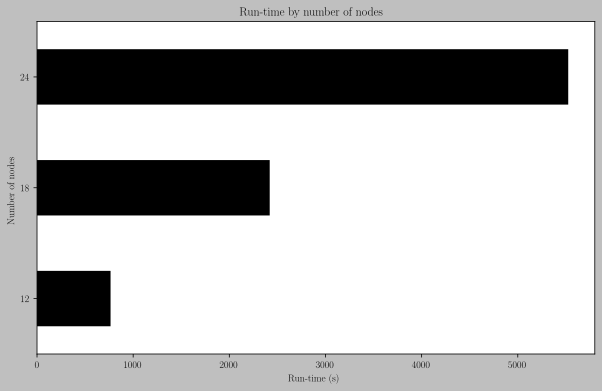

In [10]:
ax = results.run_time.groupby(results.num_nodes).mean().plot.barh(figsize=(10, 6))
ax.set_xlabel("Run-time (s)")
ax.set_ylabel("Number of nodes")
ax.set_title("Run-time by number of nodes");

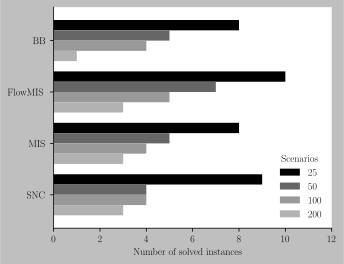

In [11]:
grouped = results.experiment.groupby([results.formulation, results.num_scen])
ax = grouped.nunique().unstack(1).plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, 12])

ax.legend(title="Scenarios", frameon=False, ncol=1, loc="lower right")

plt.savefig("out/solved_by_num_scenarios.pdf", transparent=True)

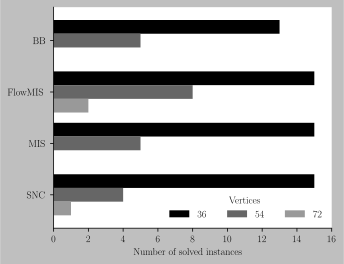

In [12]:
grouped = results.experiment.groupby([results.formulation, results.num_nodes])
ax = grouped.nunique().unstack().plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, 16])

ax.legend(["36", "54", "72"], title="Vertices", frameon=False, ncol=3, loc="lower right")

plt.savefig("out/solved_by_num_vertices.pdf", transparent=True)

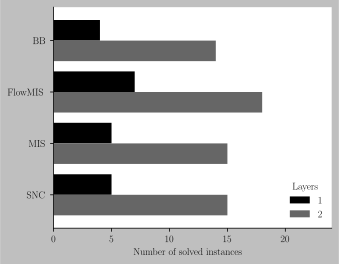

In [13]:
grouped = results.experiment.groupby([results.formulation, results.num_layers])
ax = grouped.nunique().unstack().plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, 24])

ax.legend(title="Layers", ncol=1, frameon=False, loc="lower right")

plt.savefig("out/solved_by_num_layers.pdf", transparent=True)

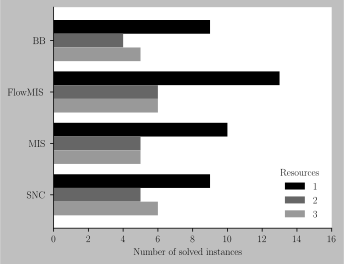

In [14]:
grouped = results.experiment.groupby([results.formulation, results.num_res])
ax = grouped.nunique().unstack().plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, 16])

ax.legend(title="Resources", frameon=False, loc="lower right")

plt.savefig("out/solved_by_num_resources.pdf", transparent=True)

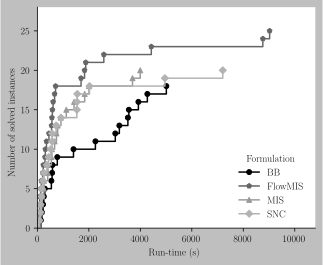

In [15]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.set_ylabel('Number of solved instances')
ax.set_xlabel('Run-time (s)')

for formulation, style in zip(FORMULATIONS, ['o', 'p', '^', 'D', 's']):
    data = list(sorted(results[results.formulation == formulation].run_time))
    data.insert(0, 0)

    ax.step(data, np.arange(len(data)), where='post', label=formulation, marker=style, markersize=5)

ax.legend(FORMULATIONS.keys(), title="Formulation", frameon=False, loc="lower right")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0, 28])
ax.set_xlim([0, 10_800])

plt.savefig("out/solved_by_runtime.pdf", transparent=True)

#### 1. BB Solves large instances (much) worse than smaller ones

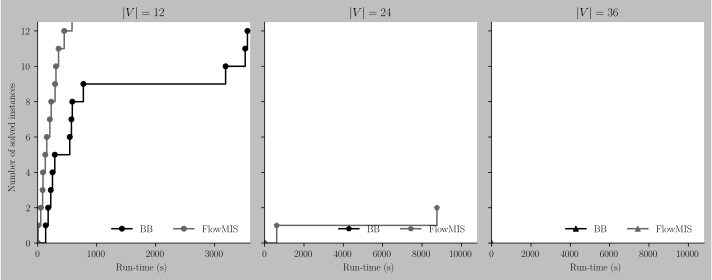

In [16]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=3, sharey=True)
axes[0].set_ylabel('Number of solved instances')

xlims = ([0, 3_600], [0, 10_800], [0, 10_800])
cmp_formulations = ["BB", "FlowMIS"]

for formulation in cmp_formulations:
    for ax, size, style, xlim in zip(axes, [12, 24, 36], ['o', 'p', '^', 'D', 's'], xlims):
        data = list(sorted(results[(results.formulation == formulation) & (results.num_nodes == size)].run_time))
        data.insert(0, 0)

        ax.step(data, np.arange(len(data)), where='post', label=formulation, marker=style, markersize=5)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.legend(cmp_formulations, frameon=False, ncol=2, loc="lower right")
        ax.set_xlabel("Run-time (s)")

        ax.set_ylim([0, 12.5])
        ax.set_xlim(xlim)
        ax.set_title(f"$|V| = {size}$")

plt.tight_layout();

#### 2. Initial iterations are pretty good, but things get worse as the candidate solution of $MP^l$ improves

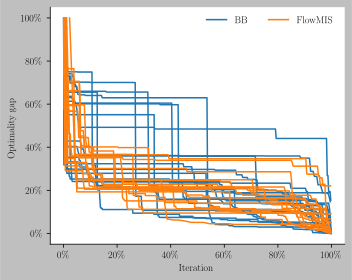

In [17]:
fig, ax = plt.subplots(figsize=(5, 4))
cmp_formulations = ["BB", "FlowMIS"]

# Shared set of experiments, that is, those BB also solved
solved = set(results[results.formulation == "BB"].experiment)

for formulation, style, colour in zip(cmp_formulations, ['o', 'p'], ["tab:blue", "tab:orange"]):
    data = results[(results.formulation == formulation) & (results.experiment.isin(solved))][["experiment", "result"]]
    
    for idx, row in data.iterrows():
        run_times = np.arange(len(row.result.run_times), dtype=float)
        run_times /= row.result.num_iters
       
        gap = row.result.objective - row.result.bounds
        gap /= row.result.objective

        # Initial gaps are +inf, so we skip those
        num_to_skip = np.count_nonzero(gap > 1e10)
        line = ax.plot(run_times[num_to_skip:], gap[num_to_skip:], color=colour)
        
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

ax.set_ylabel('Optimality gap')
ax.set_xlabel("Iteration")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

custom_lines = [Line2D([0], [0], color="tab:blue"), Line2D([0], [0], color="tab:orange")]
ax.legend(custom_lines, cmp_formulations, frameon=False, ncol=2, loc="upper right")

plt.tight_layout();

## Valid inequalities

In [18]:
def make_vi_perf_measures(df):
    df["lp_run_time"] = df.result.apply(lambda res: res.lp_run_time)
    df["lp_objective"] = df.result.apply(lambda res: res.lp_objective)
    df["mip_run_time"] = df.result.apply(lambda res: res.mip_run_time)
    df["mip_objective"] = df.result.apply(lambda res: res.mip_objective)

    return df

def make_vi_df():
    data = []
    results = []

    for experiment in experiments.index:
        data_loc = f"data/instances/{experiment}.json"
        data.append(dict(experiment=experiment, data=ProblemData.from_file(data_loc)))

        with suppress(FileNotFoundError):
            res = RootResult.from_file(f"data/results/root/{experiment}.json")
            results.append(dict(experiment=experiment, result=res))

    results = pd.DataFrame.from_records(results).join(experiments, on="experiment")
    results = results.merge(pd.DataFrame.from_records(data), on="experiment")
    
    return make_vi_perf_measures(results)

In [19]:
objs = results.objective.groupby(results.experiment).first()
vis = make_vi_df()
vis.index += 1
vis["objective"] = objs

### Distance to optimality after solving $MP^1$ on instances where the optimal value is known

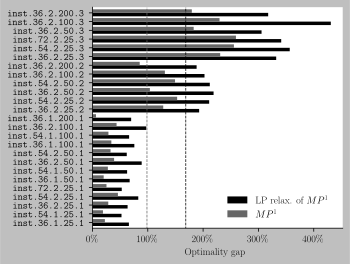

In [20]:
fltr = vis[vis.objective > 0].copy()

fltr["lp_gap"] = (fltr.objective - fltr.lp_objective) / fltr.lp_objective
fltr["mip_gap"] = (fltr.objective - fltr.mip_objective) / fltr.mip_objective

ax = fltr.plot.barh(x="experiment", y=["lp_gap", "mip_gap"], figsize=(5, 4), width=.8)

kwargs = dict(ymin=-50, ymax=50, zorder=1, linestyle='--', linewidth=.75, label="_nolegend_")
ax.vlines(fltr.lp_gap.mean(), color='0.00', **kwargs)
ax.vlines(fltr.mip_gap.mean(), color='0.4', **kwargs)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("Optimality gap")
ax.set_ylabel("")

ax.set_yticks(np.arange(len(fltr)))

if mpl.rcParams["text.usetex"]:
    ax.set_yticklabels([f"\\texttt{{{name}}}" for name in fltr.name])
else:
    ax.set_yticklabels(fltr.name)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.legend(["LP relax. of $MP^1$", "$MP^1$"], frameon=False)

plt.savefig("out/optimality_gaps_at_root.pdf", transparent=True)

In [21]:
100 * fltr[["lp_gap", "mip_gap"]].mean()

lp_gap     168.699912
mip_gap     98.528624
dtype: float64

In [22]:
novis = make_formulation_dataframe(["NoVIs"])

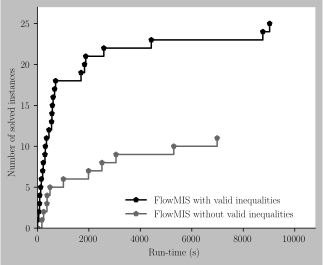

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.set_ylabel('Number of solved instances')
ax.set_xlabel('Run-time (s)')

for df, formulation in [(results, "FlowMIS"), (novis, "NoVIs")]:
    data = list(sorted(df.run_time[df.formulation == formulation]))
    data.insert(0, 0)

    ax.step(data, np.arange(len(data)), where='post', marker='p', markersize=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0, 27])
ax.set_xlim([0, 10_800])

ax.legend(["FlowMIS with valid inequalities", "FlowMIS without valid inequalities"], frameon=False, loc="lower right")

plt.savefig("out/solved_with_valid_inequalities.pdf", transparent=True)